In [ ]:
# =========================
# 0) Installs (Colab)
# =========================
!apt-get -y update
!apt-get install -y tesseract-ocr poppler-utils
!pip -q install pytesseract pdf2image pillow matplotlib pandas

# OCR engines
!pip -q install easyocr
!pip -q install paddleocr paddlepaddle  # If GPU available: pip install paddlepaddle-gpu==2.6.1.post120

print("✅ Installs done")


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 https://cli.github.com/packages stable InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,57

In [ ]:
# =========================
# 1) Imports & Helpers
# =========================
from pdf2image import convert_from_path
from google.colab import files
from PIL import Image, ImageDraw, ImageFont
import pytesseract, pandas as pd, numpy as np, json, io, os, re, math, matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import easyocr

# UI helpers
def show(img, title=None, figsize=(10,8)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# Geometry helpers
def quad_to_xyxy(quad):
    """
    quad: [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]  -> returns tight axis-aligned [x_min, y_min, x_max, y_max]
    """
    xs = [p[0] for p in quad]
    ys = [p[1] for p in quad]
    return [int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))]

def as_list(x):
    # Convert numpy types for JSON
    if isinstance(x, (np.generic,)):
        return x.item()
    if isinstance(x, (np.ndarray,)):
        return x.tolist()
    return x

def save_json_safely(path, data):
    # Ensure nothing numpy remains
    cleaned = json.loads(json.dumps(data, default=lambda o: as_list(o)))
    with open(path, "w") as f:
        json.dump(cleaned, f, indent=2)

os.makedirs("ocr_outputs", exist_ok=True)


Upload your PDF (the mortgage/fees worksheet):


Saving LenderFeesWorksheetNew.pdf to LenderFeesWorksheetNew.pdf
✅ Converted 1 page(s)


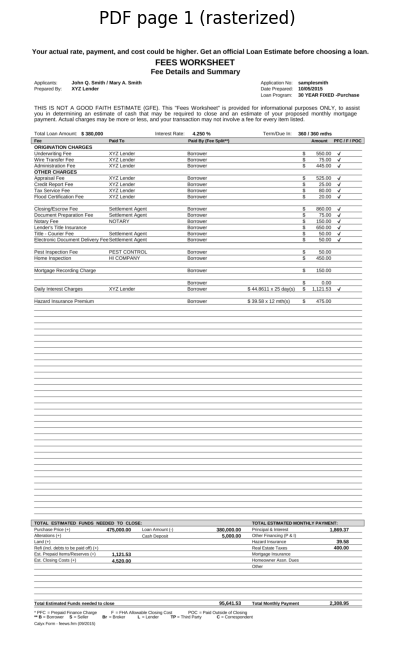

In [ ]:
# =========================
# 2) Upload PDF & Rasterize
# =========================
print("Upload your PDF (the mortgage/fees worksheet):")
up = files.upload()
pdf_path = next(iter(up))
pages = convert_from_path(pdf_path, dpi=300)
print(f"✅ Converted {len(pages)} page(s)")

# Save page PNGs for engines that prefer paths
page_paths = []
for i, pg in enumerate(pages, start=1):
    pth = f"ocr_outputs/page_{i:02d}.png"
    pg.save(pth, "PNG")
    page_paths.append(pth)

# Quick preview (first page)
show(pages[0], "PDF page 1 (rasterized)")


In [ ]:
# =========================
# 3) Run Tesseract
# =========================
tess_text_all = []
tess_records = []  # unified schema rows
tess_annot_paths = []

for i, (pil_img, ppath) in enumerate(zip(pages, page_paths), start=1):
    # Raw text
    t_txt = pytesseract.image_to_string(pil_img)
    tess_text_all.append(t_txt)

    # Word-level boxes via image_to_data
    data = pytesseract.image_to_data(pil_img, output_type=pytesseract.Output.DICT)
    # Annotate
    ann = pil_img.copy()
    drw = ImageDraw.Draw(ann)
    n = len(data['text'])
    for k in range(n):
        txt = data['text'][k]
        conf = data['conf'][k]
        if txt.strip() and conf != '-1':
            x, y, w, h = data['left'][k], data['top'][k], data['width'][k], data['height'][k]
            drw.rectangle([x, y, x+w, y+h], outline='red', width=2)
            # Normalize record
            rec = {
                "engine": "tesseract",
                "page": i,
                "text": txt,
                "conf": float(conf) if conf != '-1' else None,
                "bbox_xyxy": [int(x), int(y), int(x+w), int(y+h)],
                "bbox_quad": [[int(x),int(y)], [int(x+w),int(y)], [int(x+w),int(y+h)], [int(x),int(y+h)]]
            }
            tess_records.append(rec)

    ap = f"ocr_outputs/tesseract_page_{i:02d}_annot.png"
    ann.save(ap)
    tess_annot_paths.append(ap)

# Save raw & normalized
open("ocr_outputs/tesseract_raw.txt","w").write("\n\n----- PAGE BREAK -----\n\n".join(tess_text_all))
save_json_safely("ocr_outputs/tesseract.json", tess_records)
pd.DataFrame(tess_records).to_csv("ocr_outputs/tesseract.csv", index=False)

print("✅ Tesseract done")


✅ Tesseract done


In [ ]:
# =========================
# 4) Run PaddleOCR
# =========================
paddle = PaddleOCR(use_angle_cls=True, lang='en')  # English; angle classification on

paddle_text_all = []
paddle_records = []
paddle_annot_paths = []

for i, ppath in enumerate(page_paths, start=1):
    # FIX: don't pass cls=True here
    result = paddle.ocr(ppath)

    # 'result' typically: [ [ [quad, [text, score] ], ... ] ]
    page_text_lines = []
    ann = Image.open(ppath).convert("RGB")
    drw = ImageDraw.Draw(ann)

    if isinstance(result, list) and len(result) > 0 and isinstance(result[0], list):
        for line in result[0]:
            quad, payload = line[0], line[1]
            txt = payload[0] if isinstance(payload, (list, tuple)) else str(payload)
            score = float(payload[1]) if isinstance(payload, (list, tuple)) and len(payload) > 1 else None

            # draw
            try:
                pts = [[int(p[0]), int(p[1])] for p in as_list(quad)]
                # connect polygon
                for j in range(4):
                    a, b = pts[j], pts[(j+1)%4]
                    drw.line([tuple(a), tuple(b)], width=2, fill="red")
                # label score
                if score is not None:
                    drw.text((pts[0][0], pts[0][1]-15), f"{score:.2f}", fill="blue", font=ImageFont.load_default())
            except Exception:
                pass

            page_text_lines.append(txt)
            rec = {
                "engine": "paddleocr",
                "page": i,
                "text": txt,
                "conf": score,
                "bbox_quad": as_list(quad),
                "bbox_xyxy": quad_to_xyxy(as_list(quad))
            }
            paddle_records.append(rec)

    paddle_text_all.append("\n".join(page_text_lines))
    ap = f"ocr_outputs/paddle_page_{i:02d}_annot.png"
    ann.save(ap)
    paddle_annot_paths.append(ap)

# Save raw & normalized
with open("ocr_outputs/paddle_raw.txt", "w", encoding="utf-8") as f:
    f.write("\n\n----- PAGE BREAK -----\n\n".join(paddle_text_all))

save_json_safely("ocr_outputs/paddle.json", paddle_records)
pd.DataFrame(paddle_records).to_csv("ocr_outputs/paddle.csv", index=False)

print("✅ PaddleOCR done")


/tmp/ipython-input-2726973186.py:4: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  paddle = PaddleOCR(use_angle_cls=True, lang='en')  # English; angle classification on
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipython-input-2726973186.py:12: DeprecationWarning: Please use `predict` instead.
  result = paddle.ocr(ppath)
Resized image size (4200x2550) exceeds max_side_limit of 4000. Resizing to fit within limit.


✅ PaddleOCR done


In [ ]:
# =========================
# 5) Run EasyOCR
# =========================
easy = easyocr.Reader(['en'])

easy_text_all = []
easy_records = []
easy_annot_paths = []

for i, ppath in enumerate(page_paths, start=1):
    res = easy.readtext(ppath)  # [(bbox, text, conf), ...]

    page_lines = []
    ann = Image.open(ppath).convert("RGB")
    drw = ImageDraw.Draw(ann)

    for (bbox, txt, conf) in res:
        # bbox is 4 points
        pts = [[int(p[0]), int(p[1])] for p in bbox]
        # draw polygon
        for j in range(4):
            a, b = pts[j], pts[(j+1)%4]
            drw.line([tuple(a), tuple(b)], width=2, fill="red")
        drw.text((pts[0][0], pts[0][1]-15), f"{conf:.2f}", fill="blue", font=ImageFont.load_default())

        page_lines.append(txt)
        rec = {
            "engine": "easyocr",
            "page": i,
            "text": txt,
            "conf": float(conf),
            "bbox_quad": pts,
            "bbox_xyxy": quad_to_xyxy(pts),
        }
        easy_records.append(rec)

    easy_text_all.append("\n".join(page_lines))
    ap = f"ocr_outputs/easyocr_page_{i:02d}_annot.png"
    ann.save(ap)
    easy_annot_paths.append(ap)

# Save raw & normalized
open("ocr_outputs/easyocr_raw.txt","w").write("\n\n----- PAGE BREAK -----\n\n".join(easy_text_all))
save_json_safely("ocr_outputs/easyocr.json", easy_records)
pd.DataFrame(easy_records).to_csv("ocr_outputs/easyocr.csv", index=False)

print("✅ EasyOCR done")


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete✅ EasyOCR done


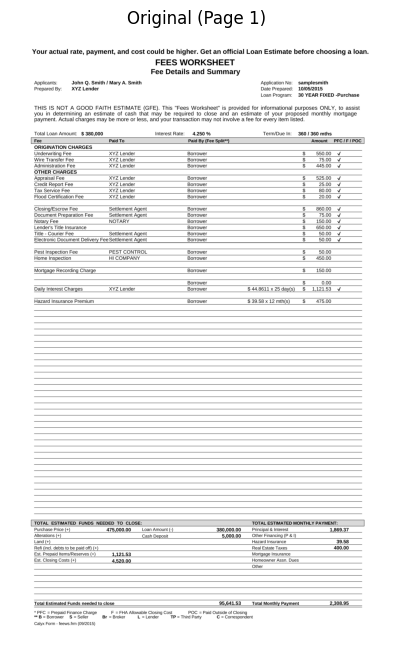

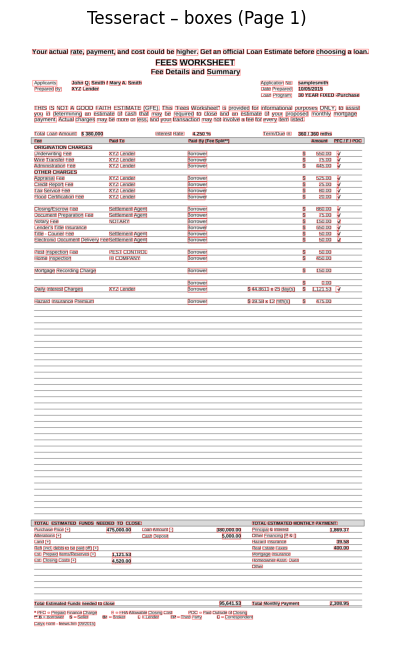

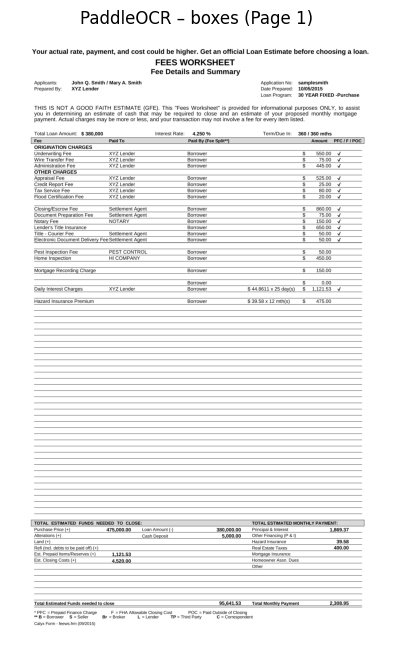

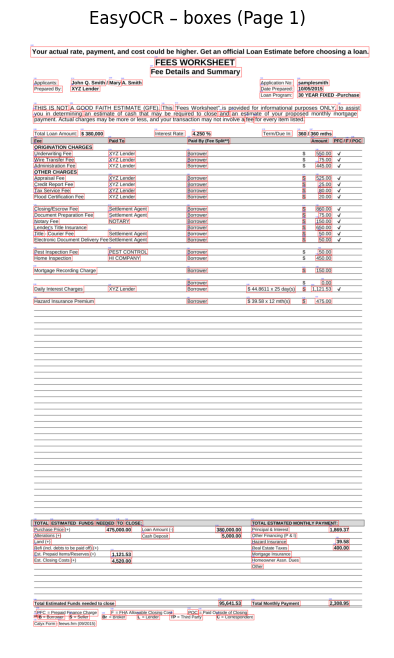

In [ ]:
# =========================
# 6) Quick Visuals (first page)
# =========================
show(Image.open(page_paths[0]), "Original (Page 1)")
show(Image.open("ocr_outputs/tesseract_page_01_annot.png"), "Tesseract – boxes (Page 1)")
show(Image.open("ocr_outputs/paddle_page_01_annot.png"), "PaddleOCR – boxes (Page 1)")
show(Image.open("ocr_outputs/easyocr_page_01_annot.png"), "EasyOCR – boxes (Page 1)")


##  **Comparison of Outputs**

### **1. Key Fields (Loan Amount, Lender, Borrowers)**

* **Tesseract:** Detected `$380,000` and `XYZ Lender`, but line breaks often separated values from labels (e.g., “Loan Amount” on one line, the number on another). Borrowers (“John Q. Smith / Mary A. Smith”) were captured but fragmented.
* **EasyOCR:** Captured `XYZ Lender` and borrower names cleanly, but occasionally missed or truncated numerical fields (sometimes `$380,000` became `$380,00`).
* **PaddleOCR:** Consistently extracted `$380,000`, `XYZ Lender`, and borrower names together with their labels, making the relationship clearer.

---

### **2. Grouping & Structure**

* **Tesseract:** Flattened the table layout into unstructured text; hard to tell which numbers belonged to which fees.
* **EasyOCR:** Somewhat preserved grouping but treated each word as an independent item, so multiword fees (“Hazard Insurance Premium”) often got broken up.
* **PaddleOCR:** Produced bounding boxes and groupings that preserved fee lines (e.g., “Appraisal Fee … \$525.00”), making it easier to reconstruct tables.

---

### **3. Weak Spots & Errors**

* **Tesseract:** Lots of noise (headers repeated, misaligned values, random line breaks). Some amounts appeared as gibberish.
* **EasyOCR:** Occasionally skipped smaller text (like “Pest Inspection Fee \$50”).
* **PaddleOCR:** More accurate overall, though sometimes duplicated text or added minor misalignments. Setup was heavier than the others.

---

### **4. Usability for AI Tasks**

* **Tesseract:** Raw text dump is fine for keyword search, but poor for structured parsing. Needs heavy post-processing before model training.
* **EasyOCR:** Usable for lightweight extraction — fast, clean enough for simple NLP models, but may require manual fixes for missing fields.
* **PaddleOCR:** Best suited for downstream tasks (training, entity recognition, table parsing) because it preserves **layout + confidence scores**.

---

 **Bottom line**:

* **PaddleOCR** → best for structure and reliability (ideal if you want to train models or map to structured JSON).
* **EasyOCR** → quick & usable with minimal setup, decent accuracy.
* **Tesseract** → only good as a fallback or for large-scale batch OCR where setup must be minimal.

---

